# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name="layer1")
    self.layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, name="layer2")
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes, name="output_layer")


  def __call__(self, x):
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    output = self.output_layer(x, activation=1)
    return output




In [ ]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    predicted_class = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.float32)
    predicted_class = tf.cast(predicted_class, tf.float32)
    correct_predictions = tf.equal(predicted_class, y_true)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y, learning_rate=learning_rate):
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    trainable_variables = neural_net.trainable_variables

    gradients = g.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        current_loss = cross_entropy(pred, batch_y)
        current_accuracy = accuracy(pred, batch_y)

        loss_history.append(current_loss)
        accuracy_history.append(current_accuracy)

        print(f"Step {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step 100, Loss: 311.6870422363281, Accuracy: 0.65625
Step 200, Loss: 179.5981903076172, Accuracy: 0.796875
Step 300, Loss: 148.91177368164062, Accuracy: 0.828125
Step 400, Loss: 153.19723510742188, Accuracy: 0.7890625
Step 500, Loss: 189.91427612304688, Accuracy: 0.8125
Step 600, Loss: 159.34091186523438, Accuracy: 0.81640625
Step 700, Loss: 137.404541015625, Accuracy: 0.8515625
Step 800, Loss: 132.67214965820312, Accuracy: 0.84765625
Step 900, Loss: 94.16983032226562, Accuracy: 0.8828125
Step 1000, Loss: 75.43937683105469, Accuracy: 0.8984375
Step 1100, Loss: 114.24629974365234, Accuracy: 0.86328125
Step 1200, Loss: 85.98234558105469, Accuracy: 0.8984375
Step 1300, Loss: 122.23783111572266, Accuracy: 0.85546875
Step 1400, Loss: 86.09796905517578, Accuracy: 0.91015625
Step 1500, Loss: 81.16690826416016, Accuracy: 0.90234375
Step 1600, Loss: 109.52242279052734, Accuracy: 0.87890625
Step 1700, Loss: 70.07682800292969, Accuracy: 0.90625
Step 1800, Loss: 75.06739807128906, Accuracy: 0.8867

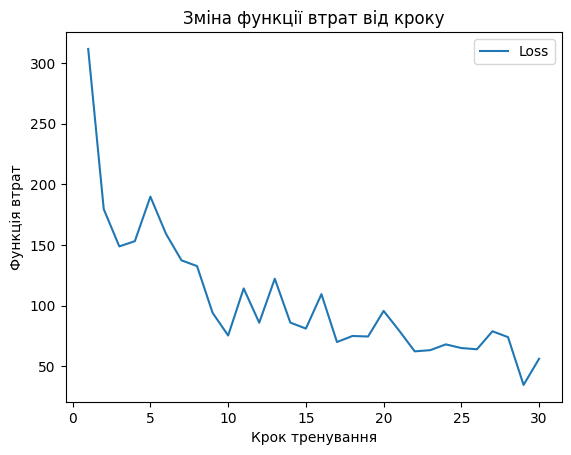

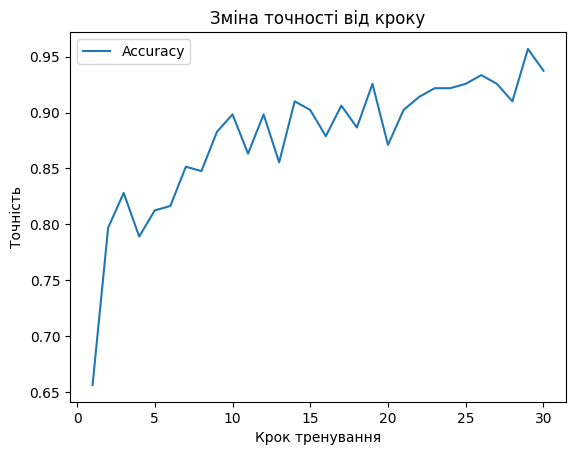

In [ ]:

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss')
plt.title('Зміна функції втрат від кроку')
plt.xlabel('Крок тренування')
plt.ylabel('Функція втрат')
plt.legend()
plt.show()

# Виведіть графік точності
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label='Accuracy')
plt.title('Зміна точності від кроку')
plt.xlabel('Крок тренування')
plt.ylabel('Точність')
plt.legend()
plt.show()


In [ ]:
test_predictions = neural_net(x_test)
all_predicted_classes = tf.argmax(test_predictions, axis=1)
test_accuracy = accuracy(test_predictions, y_test)

print(f"Точність на тестових даних: {test_accuracy.numpy()}")

Точність на тестових даних: 0.8988000154495239


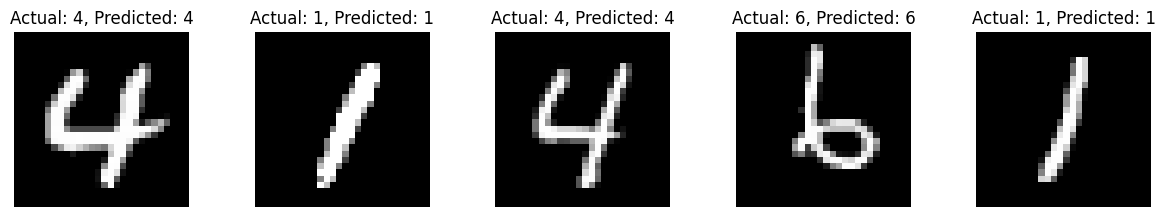

In [ ]:

random_indices = np.random.choice(len(x_test), size=5, replace=False)


sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

predictions = neural_net(sample_images)

predicted_classes = tf.argmax(predictions, axis=1).numpy()

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Actual: {sample_labels[i]}, Predicted: {predicted_classes[i]}")
    plt.axis('off')

plt.show()


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(sample_labels, predicted_classes)
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [ ]:
report = classification_report(y_test, all_predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       980
           1       0.97      0.97      0.97      1135
           2       0.88      0.89      0.88      1032
           3       0.88      0.89      0.88      1010
           4       0.89      0.89      0.89       982
           5       0.84      0.87      0.85       892
           6       0.95      0.92      0.93       958
           7       0.95      0.88      0.91      1028
           8       0.87      0.83      0.85       974
           9       0.84      0.88      0.86      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

